# Behavioural cloning

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Input, Flatten, Cropping2D, Lambda, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, History
from keras.utils.io_utils import sys
import tqdm
import csv
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Loading data

In [2]:
def load_data(file, correction=.15):
    """ This function loads a csv file into memory.
    
        It also adds an angle correction to the left and right 
        cameras images to simulate driving back to the center
        of the road.
    """

    X = []
    y = []
    with open(file, 'r') as f:   
        for row in csv.reader(f):
            X.extend(row[0:3])
            st = float(row[3])
            y.extend([st, st + correction, st - correction])
        
    print("{} samples loaded.".format(len(X)))
    return np.array(X), np.array(y)

I load diferent training sessions and concatenate them. `data2` is recorded on the mountain circuit, in both senses, and I find that it is better to reduce slightly the magnitude of the angle correction. The rest are loaded in the first circuit, in both senses too. 

It is important to note that only the paths of the images are being loaded, as to prevent filling up the memory. Later on, during the training phase the image data will be loaded and preprocessed.

In [3]:
imgs1, y1 = load_data('./data/driving_log.csv')
imgs2, y2 = load_data('./data2/driving_log.csv', correction=0.1)
imgs3, y3 = load_data('./data3/driving_log.csv')
imgs4, y4 = load_data('./data4/driving_log.csv')
imgs, y = np.hstack([imgs1, imgs2, imgs3, imgs4]), np.hstack([y1, y2, y3, y4])

18825 samples loaded.
58704 samples loaded.
27282 samples loaded.
19896 samples loaded.


## Analisis of the samples

Due to the nature of the problem there are lots of samples where no steering is performed, i.e. while driving in a straight line. I have found that removing these samples improves the performance of the model. 

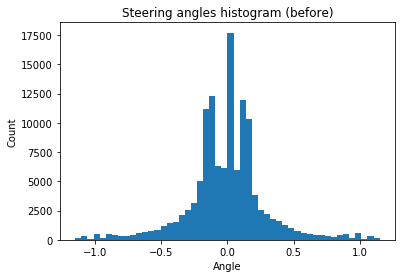

In [4]:
plt.title("Steering angles histogram (before)")
plt.xlabel("Angle")
plt.ylabel("Count")
plt.hist(y, bins=50)
plt.savefig("./examples/hist1.png")

We can appreciate that there are three large columns in the histogram, corresponding to straight line driving and the left/right cameras corrections. We only need to remove the center one, as the corrections will be useful during the training for learning how to return to the center after drifting to the side of the road.

In [17]:
# Remove samples with little angles.
idxs=np.where(np.abs(y) > 0.01)
imgs, y = imgs[idxs], y[idxs]

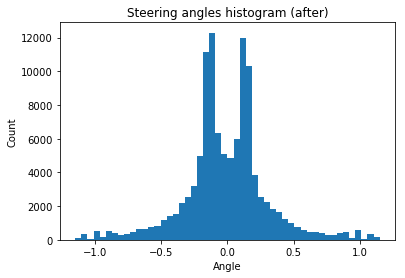

In [44]:
plt.title("Steering angles histogram (after)")
plt.xlabel("Angle")
plt.ylabel("Count")
plt.hist(y, bins=50)
plt.savefig("./examples/hist2.png")

## Batch loading of images and augmentation

It wouldn't be efficient, or even possible to load all the images into memory during training. Fortunately, Keras allows to use a generator to feed the model with batches. This is also very efficient too, as the batches are read and augmented in parallel and put in a queue in order to avoid data starvation.

This generator is also responsible of shuffling and augmenting the data. I have considered that for the sake of simplicity, it is better to crop and standarize the images in the model itself, using Keras layers. This way, during the inference phase, we can feed the model directly with the images captured from the simulator.

It is very important to shuffle the images before feeding them to the model, otherwise we would feed batches containing contiguous images that were recorded in sequence. This could cause oscillations in the cost function landscape during the training and efectively prevent the model from converging to a solution. 

In [36]:
def get_batch(X, y, batch_size, augment=lambda X, y: (X, y), shuffle=True):
    """ Batch generator.
        
        Generates batches, optionally augmenting and shuffling them.
    """
    idxs = np.arange(X.shape[0])    
    
    while 1:
        if shuffle:
            np.random.shuffle(idxs)

        for i in range(0, X.shape[0], batch_size):
            slice = idxs[i:i + batch_size]
            yield augment(np.stack(map(plt.imread, X[slice])), y[slice])

### Data augmentation

In order to duplicate the effective number of samples and to compensate the bias of the steering angle due to the shape of the circuit (i.e. circuit 1 is basically a circle), an horizontal flip is applied randomly with probability `0.5`. 

In [24]:
def augment(X, y, flip_prob=0.5):
    """ Flip augmentation 
    
        Flips horizontally the image and inverts the steering angle.
    """
    return (X, y) if np.random.uniform() > flip_prob else (np.flip(X, axis=2), -y)

### Cropping 

In order to reduce the size of the samples and consequently the model, I have considered convenient to remove the top and the bottom parts of the images. This will remove useless information and help the model to generalize better. It also hides the hood of the car that could be used by the model to cheat and guess the camera that was used.

The cropping process is incorporated into the model, using a `Cropping2D` layer from Keras. After some experimentation, I decided to crop 75 pixels from the top and 25 pixels from the bottom.

After the cropping, the images are standarized, scaling their values to the range [-0.5, 0.5]. For this, a Keras `Lambda` layer is used.

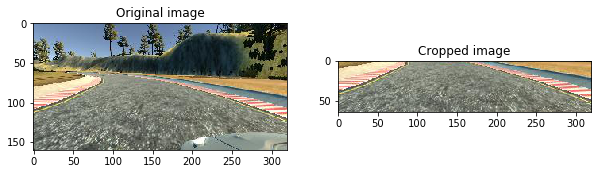

In [42]:
# Cropping example
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Original image")
plt.imshow(plt.imread(imgs[0]))
plt.subplot(122)
plt.title("Cropped image")
plt.imshow(plt.imread(imgs[0])[70:-25, ...])
plt.savefig("./examples/crop.png")

## Definition of the model

I have defined a multilayer convolutional neural network with fully connected layers at the head. I use ELUs as activation function as they give slightly better performance than ReLUs. `Dropout` layers are used to prevent overfitting in all the layers but the first. 

The model will output the steering angle to feed into the simulator. I use MSE as loss function, and an `Adam` optimizer with `learning rate = 0.0005` and leaving `beta1` and `beta2` to their default values. After some experiments, I noticed that lowering the learning rate improved the accuracy of the driving.

In [33]:
inputs = Input(shape=plt.imread(imgs[0]).shape)

x = Cropping2D(((70, 25), 0))(inputs)
# x = AveragePooling2D((1,2))(x)
x = Lambda(lambda x: x / 255. - 0.5)(x)

x = Conv2D(16, (5, 5), strides=(2, 2), padding='same', activation='elu')(x)
x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='elu')(x)
x = Dropout(0.4)(x)
x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='elu')(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='elu')(x)
x = Dropout(0.4)(x)
x = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='elu')(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (1, 1), strides=(1, 1), activation='elu')(x)
x = Dropout(0.4)(x)

# x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='elu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='elu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='elu')(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='elu')(x)
x = Dropout(0.4)(x)
predictions = Dense(1)(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0005), loss='mse')

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 160, 16)       1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 80, 32)        12832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 80, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 40, 64)         51264     
__________

## Training

I have used a Nvidia GTX 1080Ti / 11 GB for training. 

In order to prevent overfitting, I split the data into a training and a validation set. This way I can monitor the learning curves and stop the training in case the model start to overfit. This can also be done automatically with a Keras callback. As I have lots of data samples, I decided to use 10% of the data for validation.

I trained during 20 epochs the model with a batch size of 64. After that I realized that I could keep training for longer, as both loss curves were still improving. Fortunately, keras allows to extend the training without breaking the model. The final number of epochs was 30.

I also added a Keras callback to reduce the learning rate in case that a plateau was found (eventually, this wasn't necessary).

In [35]:
# Base n_experiment to prevent overwriting Tensorboard samples.
n_experiment = 90

In [14]:
n_experiment += 1
print('Experiment #{}'.format(n_experiment))

batch_size = 64
epochs = 20

X_train, X_val, y_train, y_val = train_test_split(imgs, y, test_size=0.1)
history = History()
callbacks = [
    ModelCheckpoint(filepath='./model.h5', verbose=1, save_best_only=True, period=5),
    history,
    ReduceLROnPlateau(factor=0.5, verbose=1, patience=3),
    TensorBoard(log_dir='./logs/{}'.format(n_experiment), batch_size=batch_size),
]
model.fit_generator(get_batch(X_train, y_train, augment=augment, batch_size=batch_size), 
                    epochs=epochs, 
                    steps_per_epoch=len(X_train) // batch_size, 
                    validation_data=get_batch(X_val, y_val, batch_size=batch_size), 
                    validation_steps=len(X_val) // batch_size,
                    callbacks=callbacks,                    
                   )


Experiment #91
Epoch 1/20
1558/1558 [==============================] - 117s - loss: 0.0972 - val_loss: 0.0772
Epoch 2/20
1558/1558 [==============================] - 116s - loss: 0.0774 - val_loss: 0.0672
Epoch 3/20
1558/1558 [==============================] - 116s - loss: 0.0678 - val_loss: 0.0616
Epoch 4/20
1558/1558 [==============================] - 116s - loss: 0.0645 - val_loss: 0.0598
Epoch 5/20
1558/1558 [==============================] - 115s - loss: 0.0623 - val_loss: 0.0617
Epoch 6/20
1558/1558 [==============================] - 116s - loss: 0.0602 - val_loss: 0.0552
Epoch 7/20
1558/1558 [==============================] - 116s - loss: 0.0585 - val_loss: 0.0529
Epoch 8/20
1558/1558 [==============================] - 117s - loss: 0.0571 - val_loss: 0.0514
Epoch 9/20
1558/1558 [==============================] - 117s - loss: 0.0559 - val_loss: 0.0497
Epoch 10/20
1558/1558 [==============================] - 119s - loss: 0.0549 - val_loss: 0.0506
Epoch 11/20
1558/1558 [===========

### Training curve after 20 epochs

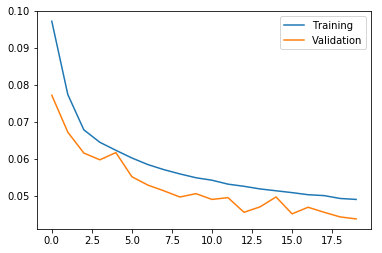

In [17]:
plt.plot(history.history['loss'][:], label='Training')
plt.plot(history.history['val_loss'][:], label='Validation')
plt.legend()

### Train 5 more epochs (2 times)

In [20]:
model.fit_generator(get_batch(X_train, y_train, augment=augment, batch_size=batch_size), 
                    epochs=5, 
                    steps_per_epoch=len(X_train) // batch_size, 
                    validation_data=get_batch(X_val, y_val, batch_size=batch_size), 
                    validation_steps=len(X_val) // batch_size,
                    callbacks=callbacks,                    
                   )


Epoch 1/5
1558/1558 [==============================] - 116s - loss: 0.0486 - val_loss: 0.0419
Epoch 2/5
1558/1558 [==============================] - 116s - loss: 0.0479 - val_loss: 0.0417
Epoch 3/5
1558/1558 [==============================] - 116s - loss: 0.0476 - val_loss: 0.0414
Epoch 4/5
1558/1558 [==============================] - 115s - loss: 0.0475 - val_loss: 0.0410
Epoch 5/5
1558/1558 [==============================] - 116s - loss: 0.0468 - val_loss: 0.0404


In [21]:
model.fit_generator(get_batch(X_train, y_train, augment=augment, batch_size=batch_size),
                    epochs=5, 
                    steps_per_epoch=len(X_train) // batch_size, 
                    validation_data=get_batch(X_val, y_val, batch_size=batch_size), 
                    validation_steps=len(X_val) // batch_size,
                    callbacks=callbacks,  
                    
                   )

Epoch 1/5
1558/1558 [==============================] - 116s - loss: 0.0465 - val_loss: 0.0400
Epoch 2/5
1558/1558 [==============================] - 116s - loss: 0.0466 - val_loss: 0.0441
Epoch 3/5
1558/1558 [==============================] - 115s - loss: 0.0460 - val_loss: 0.0424
Epoch 4/5
1558/1558 [==============================] - 116s - loss: 0.0464 - val_loss: 0.0402
Epoch 5/5
1557/1558 [============================>.] - ETA: 0s - loss: 0.0457Epoch 00004: val_loss did not improve

Epoch 00004: reducing learning rate to 0.0002500000118743628.
1558/1558 [==============================] - 116s - loss: 0.0457 - val_loss: 0.0408


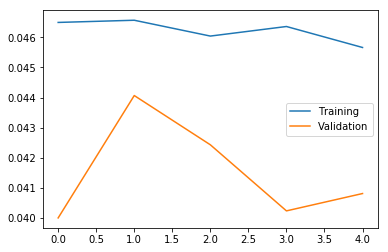

In [22]:
plt.plot(history.history['loss'][:], label='Training')
plt.plot(history.history['val_loss'][:], label='Validation')
plt.legend()

### Save model

In [23]:
model.save('model.h5')

## Drive simulator and save video

In [ ]:
!python drive.py model.h5 run91-1

In [6]:
!python video.py run91-1

Creating video run91-1.mp4, FPS=60
[MoviePy] >>>> Building video run91-1.mp4
[MoviePy] Writing video run91-1.mp4
100%|██████████████████████████████████████| 4226/4226 [00:09<00:00, 423.67it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: run91-1.mp4 



## Sample videos

This is a full autonomous lap to the first circuit. No human intervantion at all.

In [26]:
from IPython.display import HTML
HTML("<Video src={} controls/>".format('run91-1.mp4'))

This is a full autonomous lap to the second circuit. I had to correct the once the trajectory after crashing, near the end of the video. :-(

In [37]:
from IPython.display import HTML
HTML("<Video src={} controls/>".format('run91.mp4'))